## Recursive Utility Application

Prepared for WAMS 2017 by [John Stachurski](http://johnstachurski.net)


Code for studying stability of the recursion that
defines lifetime utility in Epstein-Zin preference models, with nonstationary
consumption.


#### Preliminaries

In [1]:
using QuantEcon


Function to compute spectral radius of a matrix.

In [2]:
compute_spec_rad(Q::Matrix) = maximum(abs, eigvals(Q))

compute_spec_rad (generic function with 1 method)

#### Modeling EZ Preferences


Epstein-Zin utility specification


\begin{equation*}
    V_t = \left[ 
            \zeta C_t^{1-1/\psi}
            + \beta \left\{ R_t \left(V_{t+1}
            \right) \right\}^{1-1/\psi} 
          \right]^{1/(1-1/\psi)}
\end{equation*}


where

\begin{equation*}
    R_t(V_{t+1}) 
    := ( \mathbb{E}_t  V^{1-\gamma}_{t+1} )^{1/(1-\gamma)}
\end{equation*}


* $\beta  \in (0, 1) =$ time discount factor
* $\gamma$ governs the level of relative risk aversion 
* $\psi =$ elasticity of intertemporal substitution

In [3]:
"""
Struct to store parameters of Epstein-Zin model.

"""
mutable struct EpsteinZin{T <: AbstractFloat}
    ψ::T   # Elasticity of intertemporal substitution
    γ::T   # Risk aversion parameter
    β::T   # Time discount factor
    ζ::T   # Preference factor, current consumption
    θ::T   # Derived parameter
end




"""
EpsteinZin constructor for BY model.

"""
function EpsteinZinBY(; ψ=1.5, γ=10.0, β=0.998)
    ζ = 1 - β
    θ = (1 - γ) / (1 - 1/ψ)
    return EpsteinZin(ψ, γ, β, ζ, θ) 
end

EpsteinZinBY

#### Models of Consumption Growth


Discretizing the SV model using two iterations of Rouwenhorst.

The model is 

$$    z' = ρ z + s_z σ e' $$

$$   (σ^2)' = v σ^2 + d + s_σ w' $$

where $\{e\}$ and $\{w\}$ are IID and $N(0, 1)$.  


In [4]:
mutable struct StochasticVolatility{T <: AbstractFloat}
    ρ::T
    s_z::T
    v::T
    d::T
    s_σ::T
end

In [5]:
function StochasticVolatilityBY(; ρ=0.979, 
                                  s_z=0.044,      
                                  v=0.987,       
                                  σ_bar=0.0078,   
                                  s_σ=2.3e-6)     
    d = σ_bar^2 * (1 - v)
    return StochasticVolatility(ρ, s_z, v, d, s_σ)
end

StochasticVolatilityBY (generic function with 1 method)


Discretize the SV model.  Returns a (2, M) matrix 
x_states, each element x of which is a pair (z, σ) stacked vertically, 
and a transition matrix Q such that 

    Q[m, mp] = probability of transition x_states[m] -> x_states[mp]

The strategy is to 

1. Discretize the σ process to produce state values σ_1, ..., σ_I

2. For each σ_i, 

    * discretize the z process to get $z_{i1}, ... z_{iJ}$

In each case, discretization uses Rouwenhorst's method 

The final states are constructed as 

    x_m = (z_{ij}, σ_i), where m = (i - 1) * J + j.
    
Each x_m vector is stacked as a column of x_states.  The transition
probability Q[m, n] from x_m to x_n is computed from the transition matrices
arising from the discretization of σ and z discussed above.



In [6]:
"""
Two convenience functions to switch between a single index m that 
points to elements of a matrix A_{ij} and the multi-index (ij).  The
rule taking us from ij to m is that we start at row 1 and keep counting,
starting at the first row and working down.  Thus,

    m = (i - 1) * J + j 

"""
multi_from_single(m, J) = div(m - 1, J) + 1, rem(m - 1, J) + 1
single_from_multi(i, j, J) = (i - 1) * J + j

single_from_multi (generic function with 1 method)

In [7]:
function discretize_sv(sv::StochasticVolatility, 
                        I::Integer, 
                        J::Integer; 
                        fail_with_neg_σ=false, 
                        verbose=false) 

    # Unpack names
    ρ, s_z, v, d, s_σ = sv.ρ, sv.s_z, sv.v, sv.d, sv.s_σ

    # Discretize σ first
    mc = rouwenhorst(I, v, s_σ, d)
    sig_Q, sig2 = mc.p, collect(mc.state_values)

    # This gives σ^2 values so now we take the square root
    σ_states = similar(sig2)
    if fail_with_neg_σ == true
        @assert all(sig2 .>= 0) "Discretization failed: negative σ values."
    else
        for i in 1:I
            σ_states[i] = sig2[i] < 0 ? 1e-8 : sqrt(sig2[i])
        end
    end

    # Allocate memory
    M = I * J
    z_states = Array{Float64}(I, J)
    q = Array{Float64}(I, J, J)
    x_states = Array{Float64}(2, M)
    Q = Array{Float64}(M, M)
    
    # Discretize z at each σ_i and record state values for z in z_states.
    # Also, record transition probability from z_states[i, j] to 
    # z_states[i, jp] when σ = σ_i.  Store it as q[i, j, jp].
    for (i, σ) in enumerate(σ_states)
        mc_z = rouwenhorst(J, ρ, s_z * σ, 0.0) 
        for j in 1:J
            z_states[i, j] = mc_z.state_values[j]
            for jp in 1:J
                q[i, j, jp] = mc_z.p[j, jp]  
            end
        end
    end

    # Compute x_states and Q
    for m in 1:M
        i, j = multi_from_single(m, J)
        x_states[:, m] = [z_states[i, j], σ_states[i]]
        for mp in 1:M
            ip, jp = multi_from_single(mp, J)
            Q[m, mp] = sig_Q[i, ip] * q[i, j, jp]
        end
    end

    if verbose == true
        return x_states, Q, z_states, σ_states
    else
        return x_states, Q
    end
end

discretize_sv (generic function with 1 method)

#### Solving the Bansal--Yaron Modle

In [8]:
function compute_K_bansal_yaron(ez::EpsteinZin, 
                                sv::StochasticVolatility;
                                μ=0.0015, 
                                I=10,   # discretization in σ
                                J=10)   # discretization in z for each σ

    # Unpack parameters, allocate memory
    γ, β, θ = ez.γ, ez.β, ez.θ
    M = I * J
    K = Array{Float64}(M, M)

    # Discretize SV process 
    x, Q = discretize_sv(sv, I, J)

    for m in 1:M
        for mp in 1:M
            i, j = multi_from_single(m, J)
            z, σ = x[1, m], x[2, m] 
            a = exp((1 - γ) * (μ + z) + (1 - γ)^2 * σ^2 / 2)
            K[m, mp] =  a * Q[m, mp]
        end
    end
    
    return β^θ * K

end

compute_K_bansal_yaron (generic function with 1 method)

Now let's compute $r(K)$ for the BY model under a range of parameterizations.  

In [9]:
J = 20 # grid size
ψ_vals = linspace(1.25, 2.25, J)          # ψ
μ_vals = linspace(0.0005, 0.01, J)        # μ

0.0005:0.0005:0.01

Here's the matrix that we'll populate with spectral radius values, one for each parameter pair.

In [10]:
R = Array{Float64}(J, J);

In [11]:
sv_by = StochasticVolatilityBY()

StochasticVolatility{Float64}(0.979, 0.044, 0.987, 7.909200000000006e-7, 2.3e-6)

In [12]:
for (i, ψ) in enumerate(ψ_vals)
    for (j, μ) in enumerate(μ_vals)
        ez = EpsteinZinBY(ψ=ψ)
        @assert ez.θ < 0 "Detected non-negative theta value"
        K = compute_K_bansal_yaron(ez, sv_by, μ=μ)
        R[i, j] = compute_spec_rad(K)
    end
end

#### Plots

Now let's plot the result:

In [13]:
using PyPlot
plt = PyPlot

PyPlot

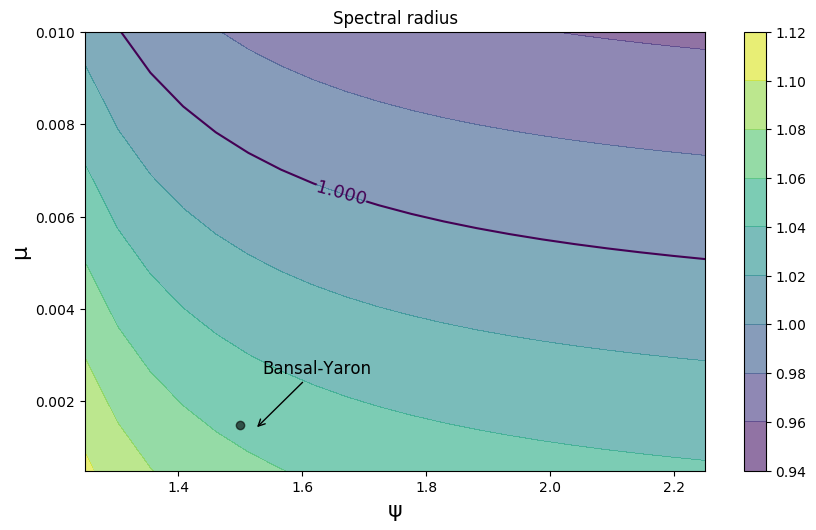

In [14]:
fig, ax = plt.subplots(figsize=(10, 5.7))

cs1 = ax[:contourf](ψ_vals, 
                    μ_vals, 
                    R',
                    alpha=0.6)

ctr1 = ax[:contour](ψ_vals, 
                    μ_vals, 
                    R', 
                    levels=[1.0])

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)

ax[:set_title]("Spectral radius")
ax[:set_xlabel]("ψ", fontsize=16)
ax[:set_ylabel]("μ", fontsize=16)


ax[:annotate]("Bansal-Yaron", 
         xy=(1.5 + 0.024, 0.0015 - 0.0001),  
         xycoords="data",
         xytext=(5, 40),
         textcoords="offset points",
         fontsize=12,
         arrowprops=Dict("arrowstyle" => "->"))

ax[:plot]([1.5], [0.0015],  "ko", alpha=0.6)

plt.show()